## Group 26
#### Members:
- Deeksha Singh (23200306)
- Suhani Bansal (23206817)
- Vaishnavi Raghavan (23201053)
- Yuvraj Singh (23200256)

## Importing dependencies

In [1]:
from collections import defaultdict 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, StatsForecastAutoARIMA

color_pal = sns.color_palette()

Importing plotly failed. Interactive plots will not work.


## Getting electricity pricing data

In [2]:
# https://www.seai.ie/data-and-insights/seai-statistics/key-statistics/prices/
commercial_pricing_data = pd.read_csv('./Commercial-Electricity.csv')
household_pricing_data = pd.read_csv('./Household-Electricity.csv')
commercial_pricing_data.rename(columns={"Average electricity price to business (Euro cent/kWh)": "timeframe"}, inplace=True)
household_pricing_data.rename(columns={"Average electricity price to households (Euro cent/kWh)": "timeframe"}, inplace=True)

In [3]:
commercial_pricing_data

,timeframe,Ireland,Euro Area,EU-27
0,2007S2,12.502179,9.38,9.06
1,2008S1,12.710000,10.61,10.19
2,2008S2,14.180000,11.00,10.60
3,2009S1,12.310000,11.51,10.91
4,2009S2,11.370000,11.13,10.66
5,2010S1,10.610000,11.28,10.83
6,2010S2,10.660000,11.45,11.00
7,2011S1,10.900000,12.04,11.53
8,2011S2,12.010000,12.34,11.67
9,2012S1,13.100000,12.67,11.98


In [4]:
household_pricing_data

,timeframe,Ireland,Euro Area,EU-27
0,S2 2007,18.21,16.03,15.67
1,S1 2008,16.60,16.67,16.33
2,S2 2008,19.34,17.48,17.11
3,S1 2009,19.31,17.87,17.17
4,S2 2009,17.72,18.00,17.38
5,S1 2010,17.05,18.28,17.79
6,S2 2010,17.88,18.73,18.26
7,S1 2011,17.23,19.50,19.03
8,S2 2011,19.89,20.00,19.36
9,S1 2012,20.40,20.23,19.57


In [5]:
def timeframeCleaner(row):
    try:
        return row['timeframe'].split()[1]
    except:
        return row['timeframe'].split('S')[0]

In [6]:
commercial_pricing_data['year'] = commercial_pricing_data.apply(lambda row: row['timeframe'].split('S')[0], axis=1)
household_pricing_data['year'] = household_pricing_data.apply(timeframeCleaner, axis=1)

In [7]:
commercial_pricing_data

,timeframe,Ireland,Euro Area,EU-27,year
0,2007S2,12.502179,9.38,9.06,2007
1,2008S1,12.710000,10.61,10.19,2008
2,2008S2,14.180000,11.00,10.60,2008
3,2009S1,12.310000,11.51,10.91,2009
4,2009S2,11.370000,11.13,10.66,2009
5,2010S1,10.610000,11.28,10.83,2010
6,2010S2,10.660000,11.45,11.00,2010
7,2011S1,10.900000,12.04,11.53,2011
8,2011S2,12.010000,12.34,11.67,2011
9,2012S1,13.100000,12.67,11.98,2012


In [8]:
new_commercial_pricing_data = pd.DataFrame(columns = ['timeframe', 'Ireland', 'Euro Area', 'EU-27', 'month', 'year'])
new_household_pricing_data = pd.DataFrame(columns = ['timeframe', 'Ireland', 'Euro Area', 'EU-27', 'month', 'year'])

In [9]:
x = 0
for index, row in commercial_pricing_data.iterrows():
    if x==12:
        x=6
    if int(row['year'])>=2010:
        for i in range(6):
            row['month'] = i+x+1
            new_commercial_pricing_data = new_commercial_pricing_data._append(row,ignore_index=True)
        x+=6

x = 0
for index, row in household_pricing_data.iterrows():
    if x==12:
        x=6
    if int(row['year'])>=2010:
        for i in range(6):
            row['month'] = i+x+1
            new_household_pricing_data = new_household_pricing_data._append(row,ignore_index=True)
        x+=6

/var/folders/1y/bj47rqw14432mn3qt_gjfjlc0000gn/T/ipykernel_1667/2858171307.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_commercial_pricing_data = new_commercial_pricing_data._append(row,ignore_index=True)
/var/folders/1y/bj47rqw14432mn3qt_gjfjlc0000gn/T/ipykernel_1667/2858171307.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_household_pricing_data = new_household_pricing_data._append(row,ignore_index=True)


In [10]:
new_commercial_pricing_data

,timeframe,Ireland,Euro Area,EU-27,month,year
0,2010S1,10.61,11.28,10.83,1,2010
1,2010S1,10.61,11.28,10.83,2,2010
2,2010S1,10.61,11.28,10.83,3,2010
3,2010S1,10.61,11.28,10.83,4,2010
4,2010S1,10.61,11.28,10.83,5,2010
...,...,...,...,...,...,...
163,2023S2,23.31,20.10,19.47,8,2023
164,2023S2,23.31,20.10,19.47,9,2023
165,2023S2,23.31,20.10,19.47,10,2023
166,2023S2,23.31,20.10,19.47,11,2023


In [11]:
new_household_pricing_data

,timeframe,Ireland,Euro Area,EU-27,month,year
0,S1 2010,17.05,18.28,17.79,1,2010
1,S1 2010,17.05,18.28,17.79,2,2010
2,S1 2010,17.05,18.28,17.79,3,2010
3,S1 2010,17.05,18.28,17.79,4,2010
4,S1 2010,17.05,18.28,17.79,5,2010
...,...,...,...,...,...,...
163,2023S2,37.48,30.98,28.77,8,2023
164,2023S2,37.48,30.98,28.77,9,2023
165,2023S2,37.48,30.98,28.77,10,2023
166,2023S2,37.48,30.98,28.77,11,2023


## Getting the data and cleaning it

In [12]:
df = pd.read_csv("./monthly_full_release_long_format-4.csv")
df['Date'] = pd.to_datetime(df['Date'])

/var/folders/1y/bj47rqw14432mn3qt_gjfjlc0000gn/T/ipykernel_1667/2157406391.py:1: DtypeWarning: Columns (1,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./monthly_full_release_long_format-4.csv")


In [13]:
# Feature Creation
df['quarter'] = df.apply(lambda row: row.Date.quarter, axis=1)
df['month'] = df.apply(lambda row: row.Date.month, axis=1)
df['year'] = df.apply(lambda row: row.Date.year, axis=1)
df['Timestamp'] = df.apply(lambda row: int(round(row.Date.timestamp())), axis=1)

In [14]:
df

,Area,Country code,Date,Area type,Continent,Ember region,EU,OECD,G20,G7,...,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change,quarter,month,year,Timestamp
0,Argentina,ARG,2018-01-01,Country,South America,Latin America and Caribbean,0.0,0.0,1.0,0.0,...,Demand,Demand,TWh,12.77,NaN,NaN,1,1,2018,1514764800
1,Argentina,ARG,2018-01-01,Country,South America,Latin America and Caribbean,0.0,0.0,1.0,0.0,...,Aggregate fuel,Clean,%,34.57,NaN,NaN,1,1,2018,1514764800
2,Argentina,ARG,2018-01-01,Country,South America,Latin America and Caribbean,0.0,0.0,1.0,0.0,...,Aggregate fuel,Fossil,%,65.44,NaN,NaN,1,1,2018,1514764800
3,Argentina,ARG,2018-01-01,Country,South America,Latin America and Caribbean,0.0,0.0,1.0,0.0,...,Aggregate fuel,Gas and Other Fossil,%,63.40,NaN,NaN,1,1,2018,1514764800
4,Argentina,ARG,2018-01-01,Country,South America,Latin America and Caribbean,0.0,0.0,1.0,0.0,...,Aggregate fuel,"Hydro, Bioenergy and Other Renewables",%,29.08,NaN,NaN,1,1,2018,1514764800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394889,World,NaN,2024-01-01,Region,NaN,NaN,NaN,NaN,NaN,NaN,...,Fuel,Other Fossil,mtCO2,54.76,-3.00,-5.19,1,1,2024,1704067200
394890,World,NaN,2024-01-01,Region,NaN,NaN,NaN,NaN,NaN,NaN,...,Fuel,Other Renewables,mtCO2,0.48,0.00,0.00,1,1,2024,1704067200
394891,World,NaN,2024-01-01,Region,NaN,NaN,NaN,NaN,NaN,NaN,...,Fuel,Solar,mtCO2,5.54,1.05,23.39,1,1,2024,1704067200
394892,World,NaN,2024-01-01,Region,NaN,NaN,NaN,NaN,NaN,NaN,...,Fuel,Wind,mtCO2,2.63,0.14,5.62,1,1,2024,1704067200


In [15]:
ireland_data = df.loc[df['Area'] == 'Ireland']

In [16]:
ireland_data.to_csv('ireland_data.csv', index=False)

In [17]:
# Unique values in each column
dictCols = {}
for col in ireland_data:
    dictCols[col] = ireland_data[col].unique()

dictCols

{'Area': array(['Ireland'], dtype=object),
 'Country code': array(['IRL'], dtype=object),
 'Date': <DatetimeArray>
 ['2010-01-01 00:00:00', '2010-02-01 00:00:00', '2010-03-01 00:00:00',
  '2010-04-01 00:00:00', '2010-05-01 00:00:00', '2010-06-01 00:00:00',
  '2010-07-01 00:00:00', '2010-08-01 00:00:00', '2010-09-01 00:00:00',
  '2010-10-01 00:00:00',
  ...
  '2023-05-01 00:00:00', '2023-06-01 00:00:00', '2023-07-01 00:00:00',
  '2023-08-01 00:00:00', '2023-09-01 00:00:00', '2023-10-01 00:00:00',
  '2023-11-01 00:00:00', '2024-01-01 00:00:00', '2024-02-01 00:00:00',
  '2024-03-01 00:00:00']
 Length: 170, dtype: datetime64[ns],
 'Area type': array(['Country'], dtype=object),
 'Continent': array(['Europe'], dtype=object),
 'Ember region': array(['Europe'], dtype=object),
 'EU': array([1.]),
 'OECD': array([1.]),
 'G20': array([0.]),
 'G7': array([0.]),
 'ASEAN': array([0.]),
 'Category': array(['Electricity demand', 'Electricity generation',
        'Electricity imports', 'Power sector em

In [18]:
# As observed above, some columns only have one unique value, so don't really add value to our forcasting model,
# so we will drop those columns.
ireland_data = ireland_data.drop(columns=['Area', 'Country code', 'Area type', 'Continent', 'Ember region', 'EU', 'OECD', 'G20', 'G7', 'ASEAN'])
ireland_data.head()

,Date,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change,quarter,month,year,Timestamp
164927,2010-01-01,Electricity demand,Demand,Demand,TWh,2.65,NaN,NaN,1,1,2010,1262304000
164928,2010-01-01,Electricity generation,Aggregate fuel,Clean,%,13.94,NaN,NaN,1,1,2010,1262304000
164929,2010-01-01,Electricity generation,Aggregate fuel,Fossil,%,86.06,NaN,NaN,1,1,2010,1262304000
164930,2010-01-01,Electricity generation,Aggregate fuel,Gas and Other Fossil,%,70.12,NaN,NaN,1,1,2010,1262304000
164931,2010-01-01,Electricity generation,Aggregate fuel,"Hydro, Bioenergy and Other Renewables",%,3.98,NaN,NaN,1,1,2010,1262304000


## Extracting relevant data and plotting it

### Ireland Demand Data

<Axes: xlabel='Date'>

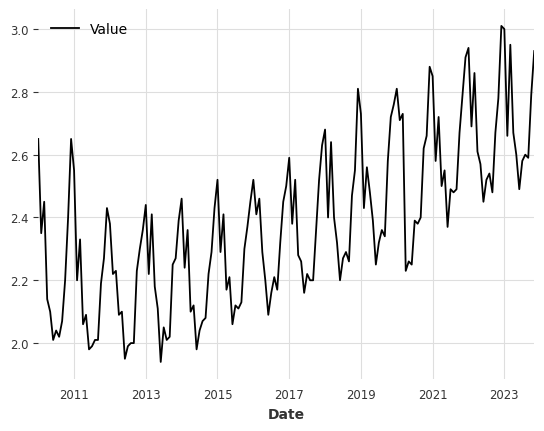

In [19]:
ireland_demand_data = ireland_data.loc[ireland_data['Category'] == 'Electricity demand']
ireland_demand_data.set_index('Date', inplace=True)
ireland_demand_data.plot(y="Value")

In [20]:
ireland_demand_data.head(30)

,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change,quarter,month,year,Timestamp
Date,,,,,,,,,,,
2010-01-01,Electricity demand,Demand,Demand,TWh,2.65,NaN,NaN,1,1,2010,1262304000
2010-02-01,Electricity demand,Demand,Demand,TWh,2.35,NaN,NaN,1,2,2010,1264982400
2010-03-01,Electricity demand,Demand,Demand,TWh,2.45,NaN,NaN,1,3,2010,1267401600
2010-04-01,Electricity demand,Demand,Demand,TWh,2.14,NaN,NaN,2,4,2010,1270080000
2010-05-01,Electricity demand,Demand,Demand,TWh,2.10,NaN,NaN,2,5,2010,1272672000
2010-06-01,Electricity demand,Demand,Demand,TWh,2.01,NaN,NaN,2,6,2010,1275350400
2010-07-01,Electricity demand,Demand,Demand,TWh,2.04,NaN,NaN,3,7,2010,1277942400
2010-08-01,Electricity demand,Demand,Demand,TWh,2.02,NaN,NaN,3,8,2010,1280620800
2010-09-01,Electricity demand,Demand,Demand,TWh,2.07,NaN,NaN,3,9,2010,1283299200


In [21]:
ireland_demand_data['commercial_average_price'] = new_commercial_pricing_data.Ireland[:-1].to_numpy()
ireland_demand_data['household_average_price'] = new_household_pricing_data.Ireland[:-1].to_numpy()

/var/folders/1y/bj47rqw14432mn3qt_gjfjlc0000gn/T/ipykernel_1667/1103595800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ireland_demand_data['commercial_average_price'] = new_commercial_pricing_data.Ireland[:-1].to_numpy()
/var/folders/1y/bj47rqw14432mn3qt_gjfjlc0000gn/T/ipykernel_1667/1103595800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ireland_demand_data['household_average_price'] = new_household_pricing_data.Ireland[:-1].to_numpy()


In [22]:
ireland_demand_data

,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change,quarter,month,year,Timestamp,commercial_average_price,household_average_price
Date,,,,,,,,,,,,,
2010-01-01,Electricity demand,Demand,Demand,TWh,2.65,NaN,NaN,1,1,2010,1262304000,10.61,17.05
2010-02-01,Electricity demand,Demand,Demand,TWh,2.35,NaN,NaN,1,2,2010,1264982400,10.61,17.05
2010-03-01,Electricity demand,Demand,Demand,TWh,2.45,NaN,NaN,1,3,2010,1267401600,10.61,17.05
2010-04-01,Electricity demand,Demand,Demand,TWh,2.14,NaN,NaN,2,4,2010,1270080000,10.61,17.05
2010-05-01,Electricity demand,Demand,Demand,TWh,2.10,NaN,NaN,2,5,2010,1272672000,10.61,17.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,Electricity demand,Demand,Demand,TWh,2.58,0.06,2.38,3,7,2023,1688169600,23.31,37.48
2023-08-01,Electricity demand,Demand,Demand,TWh,2.60,0.06,2.36,3,8,2023,1690848000,23.31,37.48
2023-09-01,Electricity demand,Demand,Demand,TWh,2.59,0.11,4.44,3,9,2023,1693526400,23.31,37.48


In [23]:
ireland_demand_data.to_csv('ireland_demand_data.csv', index=False)

In [24]:
ireland_demand_data['commercial_average_price'].corr(ireland_demand_data['Value'])

0.5188348530400989

In [25]:
ireland_demand_data.drop(columns=['Subcategory', 'Variable', 'Unit', 'Category']).corr()

,Value,YoY absolute change,YoY % change,quarter,month,year,Timestamp,commercial_average_price,household_average_price
Value,1.000000,0.351195,0.310589,-0.030309,-0.034516,0.694764,0.691395,0.518835,0.500471
YoY absolute change,0.351195,1.000000,0.995846,0.043858,0.040048,0.415196,0.417555,0.170251,0.307692
YoY % change,0.310589,0.995846,1.000000,0.040280,0.036104,0.392972,0.395061,0.140531,0.285771
quarter,-0.030309,0.043858,0.040280,1.000000,0.971446,-0.013127,0.056130,0.037706,0.297155
month,-0.034516,0.040048,0.036104,0.971446,1.000000,-0.015624,0.055667,0.033472,0.283053
year,0.694764,0.415196,0.392972,-0.013127,-0.015624,1.000000,0.997458,0.678461,0.759191
Timestamp,0.691395,0.417555,0.395061,0.056130,0.055667,0.997458,1.000000,0.679852,0.778274
commercial_average_price,0.518835,0.170251,0.140531,0.037706,0.033472,0.678461,0.679852,1.000000,0.752483
household_average_price,0.500471,0.307692,0.285771,0.297155,0.283053,0.759191,0.778274,0.752483,1.000000


,Value,quarter,month,year,Timestamp,commercial_average_price,household_average_price
Value,1.000,-0.030,-0.035,0.695,0.691,0.519,0.500
quarter,-0.030,1.000,0.971,-0.013,0.056,0.038,0.297
month,-0.035,0.971,1.000,-0.016,0.056,0.033,0.283
year,0.695,-0.013,-0.016,1.000,0.997,0.678,0.759
Timestamp,0.691,0.056,0.056,0.997,1.000,0.680,0.778
commercial_average_price,0.519,0.038,0.033,0.678,0.680,1.000,0.752
household_average_price,0.500,0.297,0.283,0.759,0.778,0.752,1.000


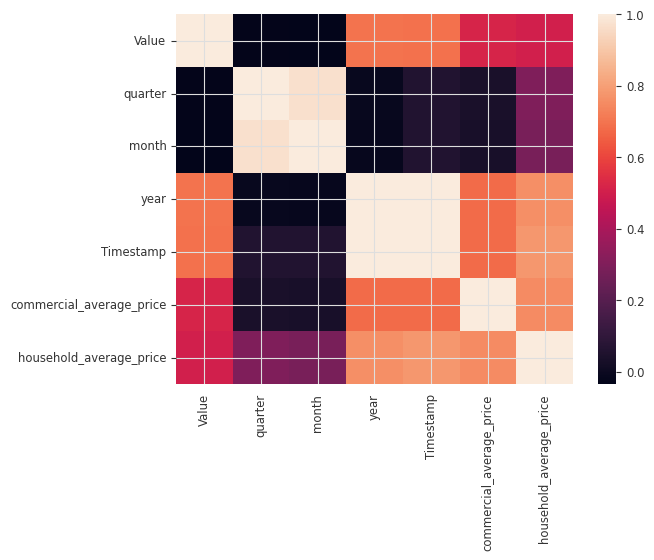

In [26]:
# calculate the correlation matrix on the numeric columns
corr = ireland_demand_data.drop(columns=['Subcategory', 'Variable', 'Unit', 'Category','YoY absolute change', 'YoY % change']).select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr)

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .format(precision=3)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Correlation Matrix")\
    .set_table_styles(magnify())

### Ireland Generation Data

In [27]:
ireland_generation_data = ireland_data.loc[ireland_data['Category'] == 'Electricity generation']

ireland_generation_fuel_data = ireland_generation_data.loc[ireland_generation_data['Subcategory']=='Fuel']
ireland_generation_fuel_twh_data = ireland_generation_fuel_data.loc[ireland_generation_fuel_data['Unit']=='TWh']

In [28]:
ireland_generation_data.head()

,Date,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change,quarter,month,year,Timestamp
164928,2010-01-01,Electricity generation,Aggregate fuel,Clean,%,13.94,NaN,NaN,1,1,2010,1262304000
164929,2010-01-01,Electricity generation,Aggregate fuel,Fossil,%,86.06,NaN,NaN,1,1,2010,1262304000
164930,2010-01-01,Electricity generation,Aggregate fuel,Gas and Other Fossil,%,70.12,NaN,NaN,1,1,2010,1262304000
164931,2010-01-01,Electricity generation,Aggregate fuel,"Hydro, Bioenergy and Other Renewables",%,3.98,NaN,NaN,1,1,2010,1262304000
164932,2010-01-01,Electricity generation,Aggregate fuel,Renewables,%,13.94,NaN,NaN,1,1,2010,1262304000


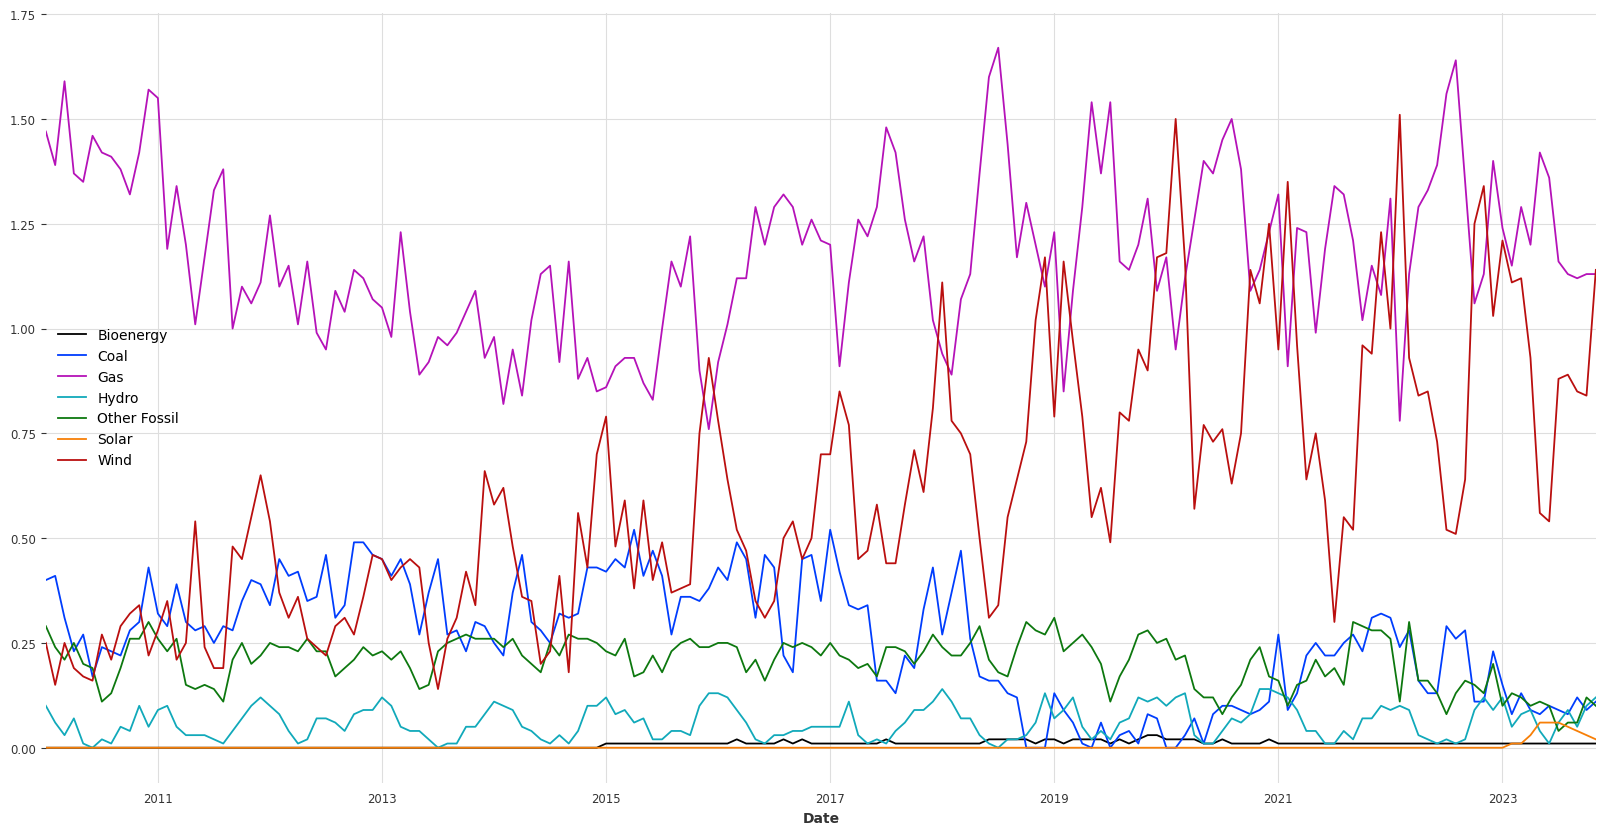

In [29]:
fig, ax = plt.subplots(figsize=(20,10))

for name, group in ireland_generation_fuel_twh_data.groupby('Variable'):
    group.plot(x='Date', y='Value', ax=ax, label=name)

plt.show()

/var/folders/1y/bj47rqw14432mn3qt_gjfjlc0000gn/T/ipykernel_1667/2263559964.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ireland_demand_data, x = 'month', y = 'Value', palette = 'Blues')


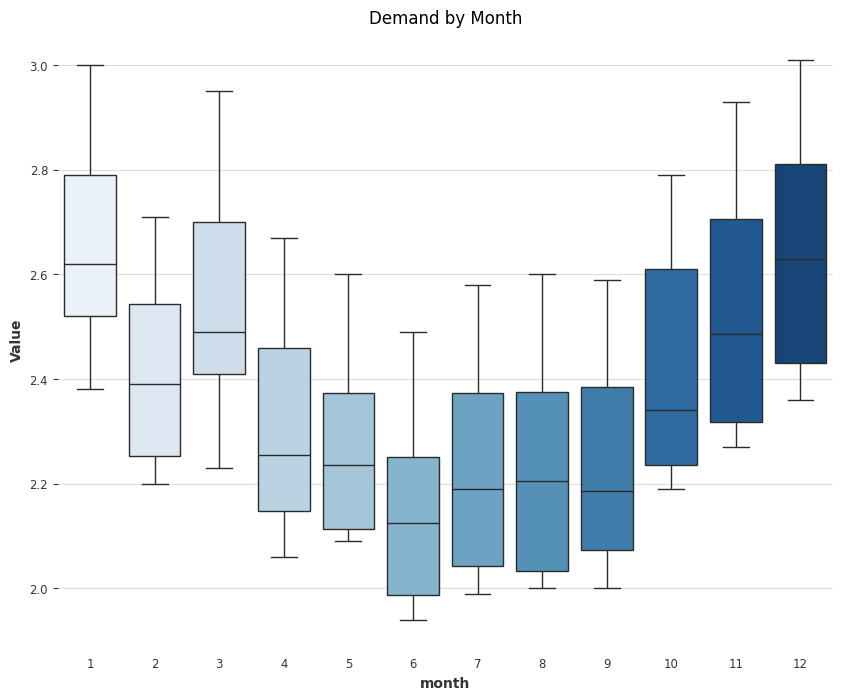

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=ireland_demand_data, x = 'month', y = 'Value', palette = 'Blues')
ax.set_title('Demand by Month')
plt.show()

## Model Creation and Training

In [31]:
#our data:
ireland_demand_data

,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change,quarter,month,year,Timestamp,commercial_average_price,household_average_price
Date,,,,,,,,,,,,,
2010-01-01,Electricity demand,Demand,Demand,TWh,2.65,NaN,NaN,1,1,2010,1262304000,10.61,17.05
2010-02-01,Electricity demand,Demand,Demand,TWh,2.35,NaN,NaN,1,2,2010,1264982400,10.61,17.05
2010-03-01,Electricity demand,Demand,Demand,TWh,2.45,NaN,NaN,1,3,2010,1267401600,10.61,17.05
2010-04-01,Electricity demand,Demand,Demand,TWh,2.14,NaN,NaN,2,4,2010,1270080000,10.61,17.05
2010-05-01,Electricity demand,Demand,Demand,TWh,2.10,NaN,NaN,2,5,2010,1272672000,10.61,17.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,Electricity demand,Demand,Demand,TWh,2.58,0.06,2.38,3,7,2023,1688169600,23.31,37.48
2023-08-01,Electricity demand,Demand,Demand,TWh,2.60,0.06,2.36,3,8,2023,1690848000,23.31,37.48
2023-09-01,Electricity demand,Demand,Demand,TWh,2.59,0.11,4.44,3,9,2023,1693526400,23.31,37.48


In [32]:
print('Subcategory:',ireland_demand_data.Subcategory.unique())
print('Variable:',ireland_demand_data.Variable.unique())
print('Unit:',ireland_demand_data.Unit.unique())
print('Category:',ireland_demand_data.Category.unique())

Subcategory: ['Demand']
Variable: ['Demand']
Unit: ['TWh']
Category: ['Electricity demand']


In [33]:
X_train, X_test, y_train, y_test = train_test_split(ireland_demand_data.drop(columns=['Subcategory', 'Variable', 'Unit', 'Category','Value'], axis=1), ireland_demand_data['Value'], test_size=.2, shuffle=False)


## XGBoost

In [34]:
# create model instance
reg = xgb.XGBRegressor() #early_stopping_rounds=50
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[0]	validation_0-rmse:0.16382	validation_1-rmse:0.33198
[1]	validation_0-rmse:0.12481	validation_1-rmse:0.29322
[2]	validation_0-rmse:0.09534	validation_1-rmse:0.25871
[3]	validation_0-rmse:0.07413	validation_1-rmse:0.23451
[4]	validation_0-rmse:0.05834	validation_1-rmse:0.21580
[5]	validation_0-rmse:0.04676	validation_1-rmse:0.17923
[6]	validation_0-rmse:0.03746	validation_1-rmse:0.16906
[7]	validation_0-rmse:0.03044	validation_1-rmse:0.14666
[8]	validation_0-rmse:0.02516	validation_1-rmse:0.13026
[9]	validation_0-rmse:0.02133	validation_1-rmse:0.11853
[10]	validation_0-rmse:0.01798	validation_1-rmse:0.11563
[11]	validation_0-rmse:0.01502	validation_1-rmse:0.10919
[12]	validation_0-rmse:0.01283	validation_1-rmse:0.10664
[13]	validation_0-rmse:0.01106	validation_1-rmse:0.10297
[14]	validation_0-rmse:0.00996	validation_1-rmse:0.10005
[15]	validation_0-rmse:0.00896	validation_1-rmse:0.09794
[16]	validation_0-rmse:0.00813	validation_1-rmse:0.09642
[17]	validation_0-rmse:0.00748	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importances'])

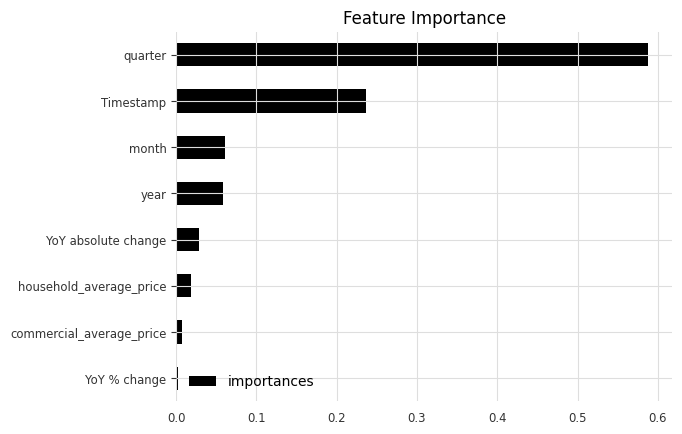

In [36]:
fi.sort_values('importances').plot(kind='barh', title='Feature Importance')
plt.show()

### Forcast on test

In [37]:
X_test_predictions = reg.predict(X_test)

In [38]:
future = pd.date_range('2023-11-01', '2033-11-01', freq='MS')
future_df = pd.DataFrame({'Date':future})

In [39]:
future_df['Timestamp'] = future_df.apply(lambda row: int(round(row.Date.timestamp())), axis=1)

In [40]:
future_df.set_index('Date', inplace=True)

In [41]:
future_concat_df = pd.concat([ireland_demand_data, future_df])

In [42]:
future_concat_df

,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change,quarter,month,year,Timestamp,commercial_average_price,household_average_price
Date,,,,,,,,,,,,,
2010-01-01,Electricity demand,Demand,Demand,TWh,2.65,NaN,NaN,1.0,1.0,2010.0,1262304000,10.61,17.05
2010-02-01,Electricity demand,Demand,Demand,TWh,2.35,NaN,NaN,1.0,2.0,2010.0,1264982400,10.61,17.05
2010-03-01,Electricity demand,Demand,Demand,TWh,2.45,NaN,NaN,1.0,3.0,2010.0,1267401600,10.61,17.05
2010-04-01,Electricity demand,Demand,Demand,TWh,2.14,NaN,NaN,2.0,4.0,2010.0,1270080000,10.61,17.05
2010-05-01,Electricity demand,Demand,Demand,TWh,2.10,NaN,NaN,2.0,5.0,2010.0,1272672000,10.61,17.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003788800,NaN,NaN
2033-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006467200,NaN,NaN
2033-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009145600,NaN,NaN


In [43]:
future_preds = reg.predict(future_concat_df.drop(columns=['Subcategory', 'Variable', 'Unit', 'Category','Value'], axis=1))

In [44]:
future_concat_df['predictions'] = future_preds

In [45]:
future_concat_df

,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change,quarter,month,year,Timestamp,commercial_average_price,household_average_price,predictions
Date,,,,,,,,,,,,,,
2010-01-01,Electricity demand,Demand,Demand,TWh,2.65,NaN,NaN,1.0,1.0,2010.0,1262304000,10.61,17.05,2.648810
2010-02-01,Electricity demand,Demand,Demand,TWh,2.35,NaN,NaN,1.0,2.0,2010.0,1264982400,10.61,17.05,2.351471
2010-03-01,Electricity demand,Demand,Demand,TWh,2.45,NaN,NaN,1.0,3.0,2010.0,1267401600,10.61,17.05,2.450163
2010-04-01,Electricity demand,Demand,Demand,TWh,2.14,NaN,NaN,2.0,4.0,2010.0,1270080000,10.61,17.05,2.138597
2010-05-01,Electricity demand,Demand,Demand,TWh,2.10,NaN,NaN,2.0,5.0,2010.0,1272672000,10.61,17.05,2.100515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003788800,NaN,NaN,2.879771
2033-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006467200,NaN,NaN,2.879771
2033-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009145600,NaN,NaN,2.879771


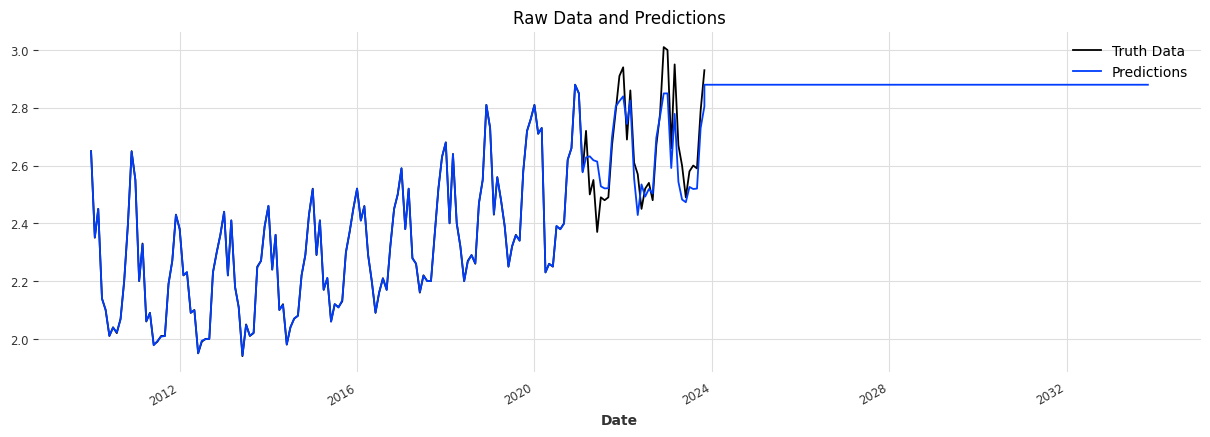

In [46]:
ax = future_concat_df[['Value']].plot(figsize=(15,5))
future_concat_df['predictions'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

In [47]:
y_test = pd.DataFrame(y_test)

In [48]:
y_test['predictions'] = X_test_predictions

In [49]:
ireland_demand_data = ireland_demand_data.merge(y_test[['predictions']], how='left', left_index=True, right_index=True)

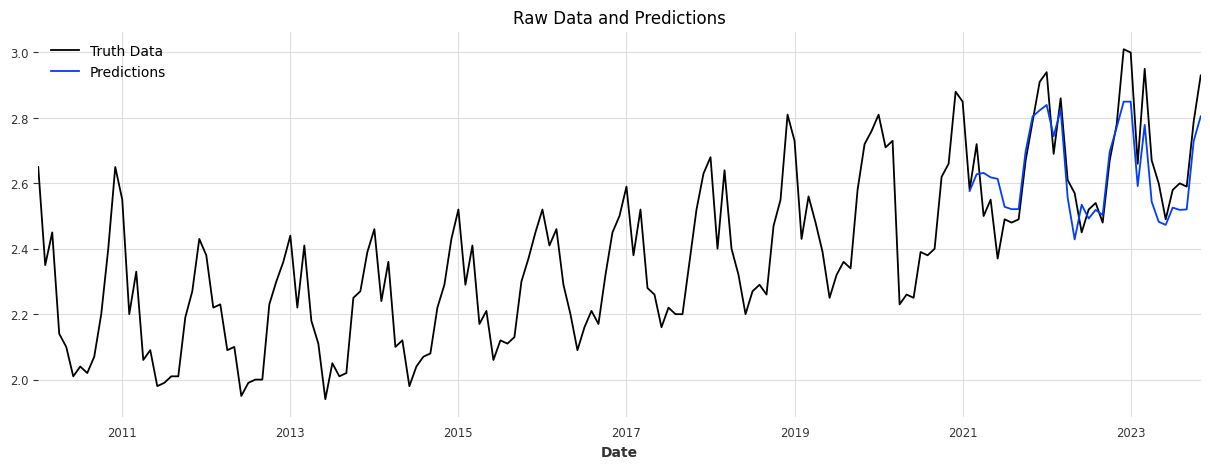

In [50]:
ax = ireland_demand_data[['Value']].plot(figsize=(15,5))
ireland_demand_data['predictions'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

In [51]:
#Mean squared error for our model:
score = np.sqrt(mean_squared_error(ireland_demand_data.Value, reg.predict(ireland_demand_data.drop(columns=['Subcategory','Variable','Unit','Category','Value','predictions']))))
print("RMSE:", score)

RMSE: 0.042077988892644844


In [52]:
ireland_demand_data

,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change,quarter,month,year,Timestamp,commercial_average_price,household_average_price,predictions
Date,,,,,,,,,,,,,,
2010-01-01,Electricity demand,Demand,Demand,TWh,2.65,NaN,NaN,1,1,2010,1262304000,10.61,17.05,NaN
2010-02-01,Electricity demand,Demand,Demand,TWh,2.35,NaN,NaN,1,2,2010,1264982400,10.61,17.05,NaN
2010-03-01,Electricity demand,Demand,Demand,TWh,2.45,NaN,NaN,1,3,2010,1267401600,10.61,17.05,NaN
2010-04-01,Electricity demand,Demand,Demand,TWh,2.14,NaN,NaN,2,4,2010,1270080000,10.61,17.05,NaN
2010-05-01,Electricity demand,Demand,Demand,TWh,2.10,NaN,NaN,2,5,2010,1272672000,10.61,17.05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,Electricity demand,Demand,Demand,TWh,2.58,0.06,2.38,3,7,2023,1688169600,23.31,37.48,2.525789
2023-08-01,Electricity demand,Demand,Demand,TWh,2.60,0.06,2.36,3,8,2023,1690848000,23.31,37.48,2.518823
2023-09-01,Electricity demand,Demand,Demand,TWh,2.59,0.11,4.44,3,9,2023,1693526400,23.31,37.48,2.520252


In [53]:
ireland_demand_data['Date'] = ireland_demand_data.index

In [54]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(ireland_demand_data, 'Date', "Value")
# incase shit hits the fan: fill_missing_dates=True, freq="MS"

# Set aside the last 36 months as a validation series
train, val = series[:-36], series[-36:]

In [55]:
train

<TimeSeries (DataArray) (Date: 131, component: 1, sample: 1)> Size: 1kB
array([[[2.65]],

       [[2.35]],

       [[2.45]],

       [[2.14]],

       [[2.1 ]],

       [[2.01]],

       [[2.04]],

       [[2.02]],

       [[2.07]],

       [[2.2 ]],

...

       [[2.71]],

       [[2.73]],

       [[2.23]],

       [[2.26]],

       [[2.25]],

       [[2.39]],

       [[2.38]],

       [[2.4 ]],

       [[2.62]],

       [[2.66]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1kB 2010-01-01 2010-02-01 ... 2020-11-01
  * component  (component) object 8B 'Value'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## Exponential Smoothening

RMSE Score: 0.10282163487362452


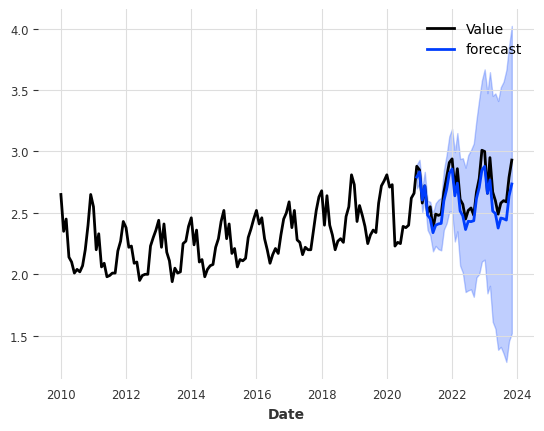

In [56]:
model_exponential_smoothing = ExponentialSmoothing()
model_exponential_smoothing.fit(train)
prediction_exponential_smoothing = model_exponential_smoothing.predict(len(val), num_samples=1000)
print("RMSE Score:",darts.metrics.metrics.rmse(val, prediction_exponential_smoothing))
series.plot()
prediction_exponential_smoothing.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

## Prophet

00:06:54 - cmdstanpy - INFO - Chain [1] start processing
00:06:54 - cmdstanpy - INFO - Chain [1] done processing


RMSE Score: 0.052830859642305605


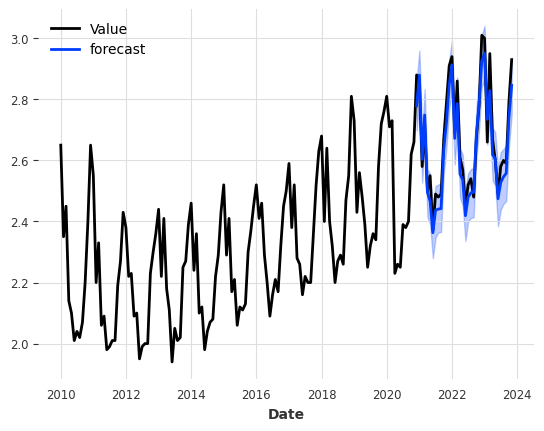

In [57]:
model_Prophet = Prophet()
model_Prophet.fit(train)
prediction_Prophet = model_Prophet.predict(len(val), num_samples=1000)
prediction_Prophet_raw = model_Prophet.predict_raw(len(val))
print("RMSE Score:",darts.metrics.metrics.rmse(val, prediction_Prophet))
series.plot()
prediction_Prophet.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [58]:
prediction_Prophet_raw

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-12-01,2.563488,2.711949,2.842207,2.563475,2.563496,0.214429,0.214429,0.214429,0.214429,0.214429,0.214429,0.0,0.0,0.0,2.777917
1,2021-01-01,2.568153,2.812173,2.938108,2.567949,2.568323,0.307084,0.307084,0.307084,0.307084,0.307084,0.307084,0.0,0.0,0.0,2.875237
2,2021-02-01,2.572819,2.545793,2.665713,2.572385,2.573249,0.033523,0.033523,0.033523,0.033523,0.033523,0.033523,0.0,0.0,0.0,2.606342
3,2021-03-01,2.577032,2.688179,2.806936,2.576237,2.577785,0.170093,0.170093,0.170093,0.170093,0.170093,0.170093,0.0,0.0,0.0,2.747125
4,2021-04-01,2.581698,2.432378,2.561500,2.580388,2.582894,-0.087555,-0.087555,-0.087555,-0.087555,-0.087555,-0.087555,0.0,0.0,0.0,2.494143
5,2021-05-01,2.586213,2.406314,2.540021,2.584301,2.587933,-0.116294,-0.116294,-0.116294,-0.116294,-0.116294,-0.116294,0.0,0.0,0.0,2.469919
6,2021-06-01,2.590878,2.300681,2.421758,2.588306,2.593081,-0.230546,-0.230546,-0.230546,-0.230546,-0.230546,-0.230546,0.0,0.0,0.0,2.360332
7,2021-07-01,2.595393,2.368411,2.498086,2.592160,2.598167,-0.161343,-0.161343,-0.161343,-0.161343,-0.161343,-0.161343,0.0,0.0,0.0,2.434050
8,2021-08-01,2.600058,2.377110,2.503496,2.596002,2.603400,-0.160084,-0.160084,-0.160084,-0.160084,-0.160084,-0.160084,0.0,0.0,0.0,2.439974
9,2021-09-01,2.604724,2.374849,2.505024,2.600044,2.608711,-0.162548,-0.162548,-0.162548,-0.162548,-0.162548,-0.162548,0.0,0.0,0.0,2.442176


In [59]:
real_values = list(map(lambda v: v[0], list(val.values())))

In [60]:
comp = pd.DataFrame({'Date':prediction_Prophet_raw['ds'],'Real Value':real_values, 'predicted_value':prediction_Prophet_raw['yhat']})

In [61]:
comp

,Date,Real Value,predicted_value
0,2020-12-01,2.88,2.777917
1,2021-01-01,2.85,2.875237
2,2021-02-01,2.58,2.606342
3,2021-03-01,2.72,2.747125
4,2021-04-01,2.50,2.494143
5,2021-05-01,2.55,2.469919
6,2021-06-01,2.37,2.360332
7,2021-07-01,2.49,2.434050
8,2021-08-01,2.48,2.439974
9,2021-09-01,2.49,2.442176


In [62]:
comp.to_csv('predicted_vs_real.csv', index=False)

## AutoARIMA

RMSE Score: 0.19087080949072227


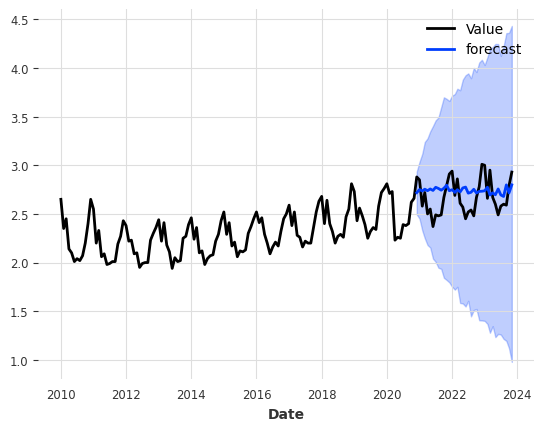

In [63]:
model_AutoARIMA = StatsForecastAutoARIMA()
model_AutoARIMA.fit(train)
prediction_AutoARIMA = model_AutoARIMA.predict(len(val), num_samples=1000)
print("RMSE Score:",darts.metrics.metrics.rmse(val, prediction_AutoARIMA))
series.plot()
prediction_AutoARIMA.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

### Considering above RMSE scores, let's use PROPHET to forcast for the next few years:

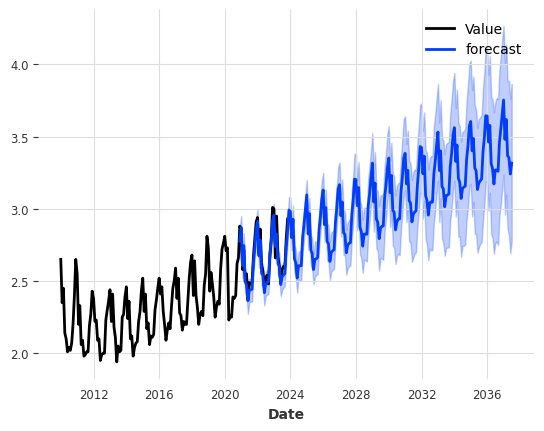

In [64]:
prediction_Prophet = model_Prophet.predict(200, num_samples=1000)
series.plot()
prediction_Prophet.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()